# Graded Challenge 7 (P2W1)

## 1. Introduction

Nama    : Muhammad Daffa  
Program : Full Time Data Science  
Batch   : BSD-007

***Background:***   
Music streaming application is becoming more a competitive market lately. Therefore, application developer require to address their services based on what the customer want and become a customer centric. This project will address the sentiment analysis on the review made by customer's of Spotify app and create a model that can accurately predict the sentiment review with at least 85% accuracy.

***Objective:***
1. Identify Good and Bad review from the Spotify Customer
2. Explore what content is related to the good review and bad review
3. Perform improvement strategy based on sentiment analysis

***Datasource URL:*** https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022/data

***Deployment URL:*** https://huggingface.co/spaces/Muhammad-Daffa/Sentiment-Review-Prediction

---

## 2. Import Libraries

This section will import libraries that will be used to model NLP Neutral Network. Additionally, this project will utilize tensorflow version 2.15 and contractions library.

In [ ]:
# Downgrade Tensorflow to 2.15 version
!pip install --upgrade "tensorflow<2.16" "tf-keras<2.16"

In [ ]:
# Installing contractions (required in text preprocessing)
!pip install contractions

In [3]:
from google.colab import drive # Importing libraries that will be used in the project

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import string
import re
from wordcloud import WordCloud
import contractions


import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras import regularizers



from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, f1_score


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 3. Data Loading

Data obtained from kaggle is moved to personal google drive.

In [ ]:
# Mount colab with google drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/dataset/"

In [5]:
# Loading the data from personal google drive.
data_ori = pd.read_csv('/content/drive/My Drive/dataset/spotify_review.csv')
data_ori

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...,...
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1,NaN


Create new dataframe with only column that will be processed in this NLP Project. Overall, we will only use the Review and Rating column for further processing. Thus, other columns will be dropped.

In [6]:
# Create new DataFrame for Review and Rating column
data = data_ori.drop(['Time_submitted', 'Reply', 'Total_thumbsup'], axis = 1)
data

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1
...,...,...
61589,Even though it was communicated that lyrics fe...,1
61590,"Use to be sooo good back when I had it, and wh...",1
61591,This app would be good if not for it taking ov...,2
61592,The app is good hard to navigate and won't jus...,2


In [7]:
# Check Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  61594 non-null  object
 1   Rating  61594 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 962.5+ KB


Data is already in the correct form. Which are object/string for review column and integer for rating column.  
Further, we need to check the missing value and duplicated value inside the dataframe

In [8]:
# Check Missing Value
data.isnull().sum()

,0
Review,0
Rating,0


No missing values detected in the dataframe

In [9]:
# Check duplicated value
data.duplicated().sum()

201

There are 201 duplicated values in our data, then we need to drop this duplicated value before further processing

In [10]:
# Drop duplicated value
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

No more duplicated value presence in the dataframe

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61393 entries, 0 to 61593
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  61393 non-null  object
 1   Rating  61393 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


There are 61,393 rows available in the dataframe after handling missing and duplicated value

In [12]:
# Check dataset (numerical type)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,61393.0,3.152835,1.672742,1.0,1.0,3.0,5.0,5.0


In [13]:
# Check dataset (object/string type)
data.describe(include = 'O').T

,count,unique,top,freq
Review,61393,61356,Too much ads,5


The purpose of this project is to performed sentimental analysis based on the review. Thus, we will create new dataframe that converts the rating to the sentiment categorization of Good and Bad using the following criteria:
1. Rating 4 & 5 = Good
2. Rating 1 - 3 = Bad

The reason we create 2 sentiment is because inside the review of rating 4 and 5 show positive/good review. However, the review inside rating 1-3 indicates bad/negative review

We will keep the existing original dataframe for Exploratory Data Analysis purpose in the rating area

In [14]:
# Create New DataFrame for Sentiment Analysis
df = data.copy()

In [15]:
# Converting the rating value to sentiment categorization

# Setting the conditions
rating_condition = [
    (data['Rating'] > 3),
    # (data['Rating'] == 3),
    (data['Rating'] <= 3)
]
rating = ['Good', 'Bad']

# Enter a value for the new column based on the conditions above
df['Rating'] = np.select(rating_condition, rating)

In [16]:
df.head()

,Review,Rating
0,"Great music service, the audio is high quality...",Good
1,Please ignore previous negative rating. This a...,Good
2,"This pop-up ""Get the best Spotify experience o...",Good
3,Really buggy and terrible to use as of recently,Bad
4,Dear Spotify why do I get songs that I didn't ...,Bad


Data Loading is completed and ready for further processing

---

## 4. Exploratory Data Analysis (EDA)

This section will explore more and provide better understanding of the content of the dataset

### 4.1 Rating Distribution

First, we want to know the distribution of sentiment / review from the customer

In [17]:
# Aggregate Count for Rating (1-5)
rating_count = data.groupby('Rating').count()

# Aggregate Count for Review (Sentiment)
rating_sentiment = df.groupby('Rating').count()

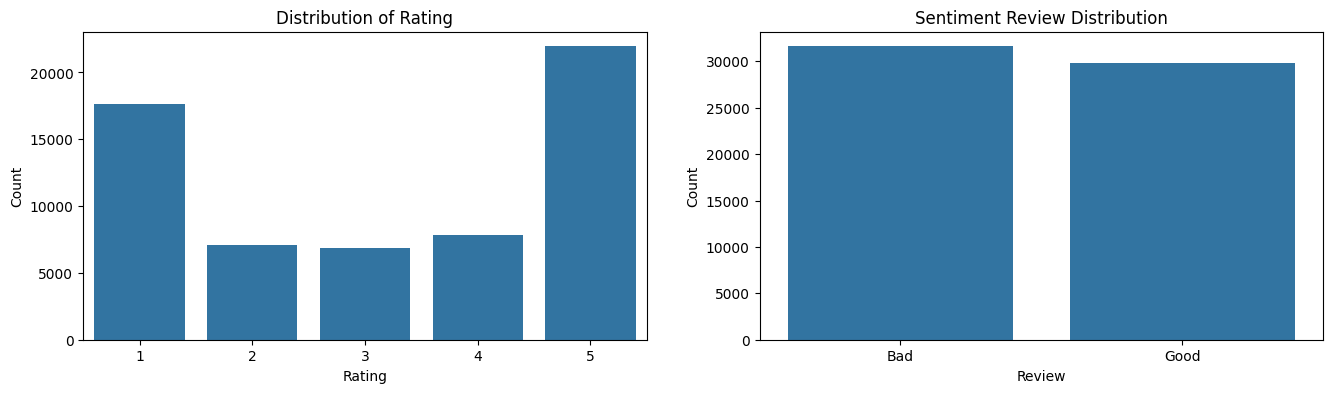

In [18]:
# Define figure size
plt.figure(figsize=(16, 4))

# Plotting Rating 1-5 Distribution
plt.subplot(1, 2, 1)
sns.barplot(x=rating_count.index, y=rating_count['Review'])
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

# Plotting Rating Sentiment Distribution
plt.subplot(1, 2, 2)
sns.barplot(x=rating_sentiment.index, y=rating_sentiment['Review'])
plt.title('Sentiment Review Distribution')
plt.xlabel('Review')
plt.ylabel('Count')

plt.show()

Based on the visualization above, it is shown that most of our customer are rating our application either 1 (very bad) or 5 (very good). Overall, we have a balance target of sentiment review from the customer.

We also want to know the percentage contribution of sentiment review in our overall dataframe

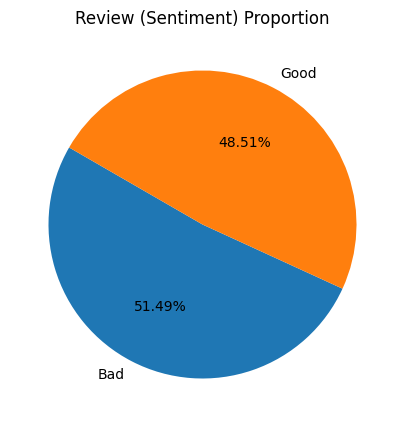

In [19]:
# Plotting Pie Chart for Sentiment Review

plt.figure(figsize=(7, 5))
plt.pie(x=rating_sentiment['Review'], labels=rating_sentiment.index, autopct='%.2f%%', startangle=150)
plt.title('Review (Sentiment) Proportion')
plt.show()

We have relatively ***balance of Good and Bad Review***. With overall 48.5% of good review and 51.5% of bad review

### 4.2 Word Plot

We also would like to know the most common words used in our review.  

***Note:***

By default, wordcloud only display the meaningful / unique words that is not included in the stopword / most common words used.

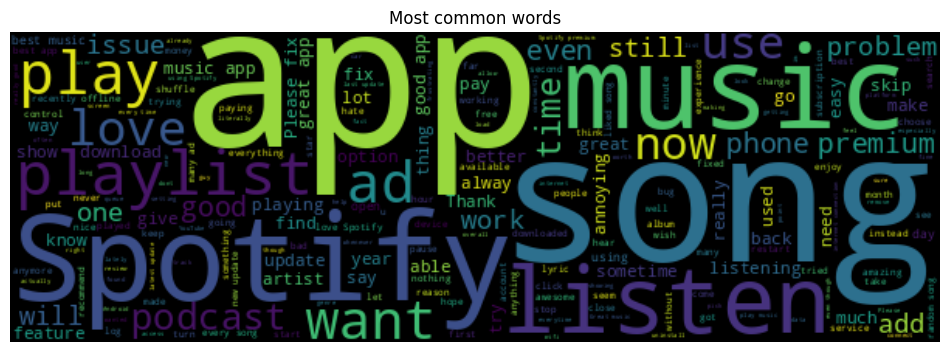

In [20]:
# Plotting Word Cloud
plt.figure(figsize=(12, 7))
wordcloud = WordCloud(max_words=1500, width=600, background_color='black').generate(" ".join(df['Review']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Most common words")
plt.axis("off")
plt.show()

We would like to know the top 10 words used based on the wordcloud

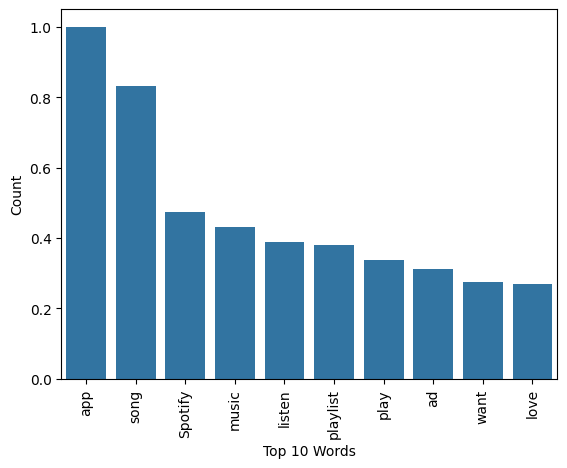

In [21]:
# Displaying top 10 words being used the most (based from wordcloud)
x = []
y = []
for key,value in wordcloud.words_.items():
    x.append(key)
    y.append(value)
    if len(x) == 10:
        break
sns.barplot(x=x,y=y)
plt.title("")
plt.xlabel("Top 10 Words")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

Plot above shows 10 most used words in the review (based on wordcloud, which is excluding the general words or stopwords)

Additionally, we also want to know what are the overall words included in our review. This will count for every word presence in the dataset, including words that inside stopword

In [22]:
# Displaying top 50 most used words before data preprocessing

FreqOfWords = df['Review'].str.split(expand=True).stack().value_counts()
FreqOfWords_top50 = FreqOfWords[:50]

fig = px.treemap(FreqOfWords_top50, path=[FreqOfWords_top50.index], values=FreqOfWords_top50)
fig.update_layout(title_text='Top used 50 Words (Before Data Preprocessing)',
                  title_x=0.5, title_font=dict(size=18),
                  treemapcolorway = ['red', 'green', 'blue']
                  )
fig.update_traces(textinfo="label+value")
fig.show()

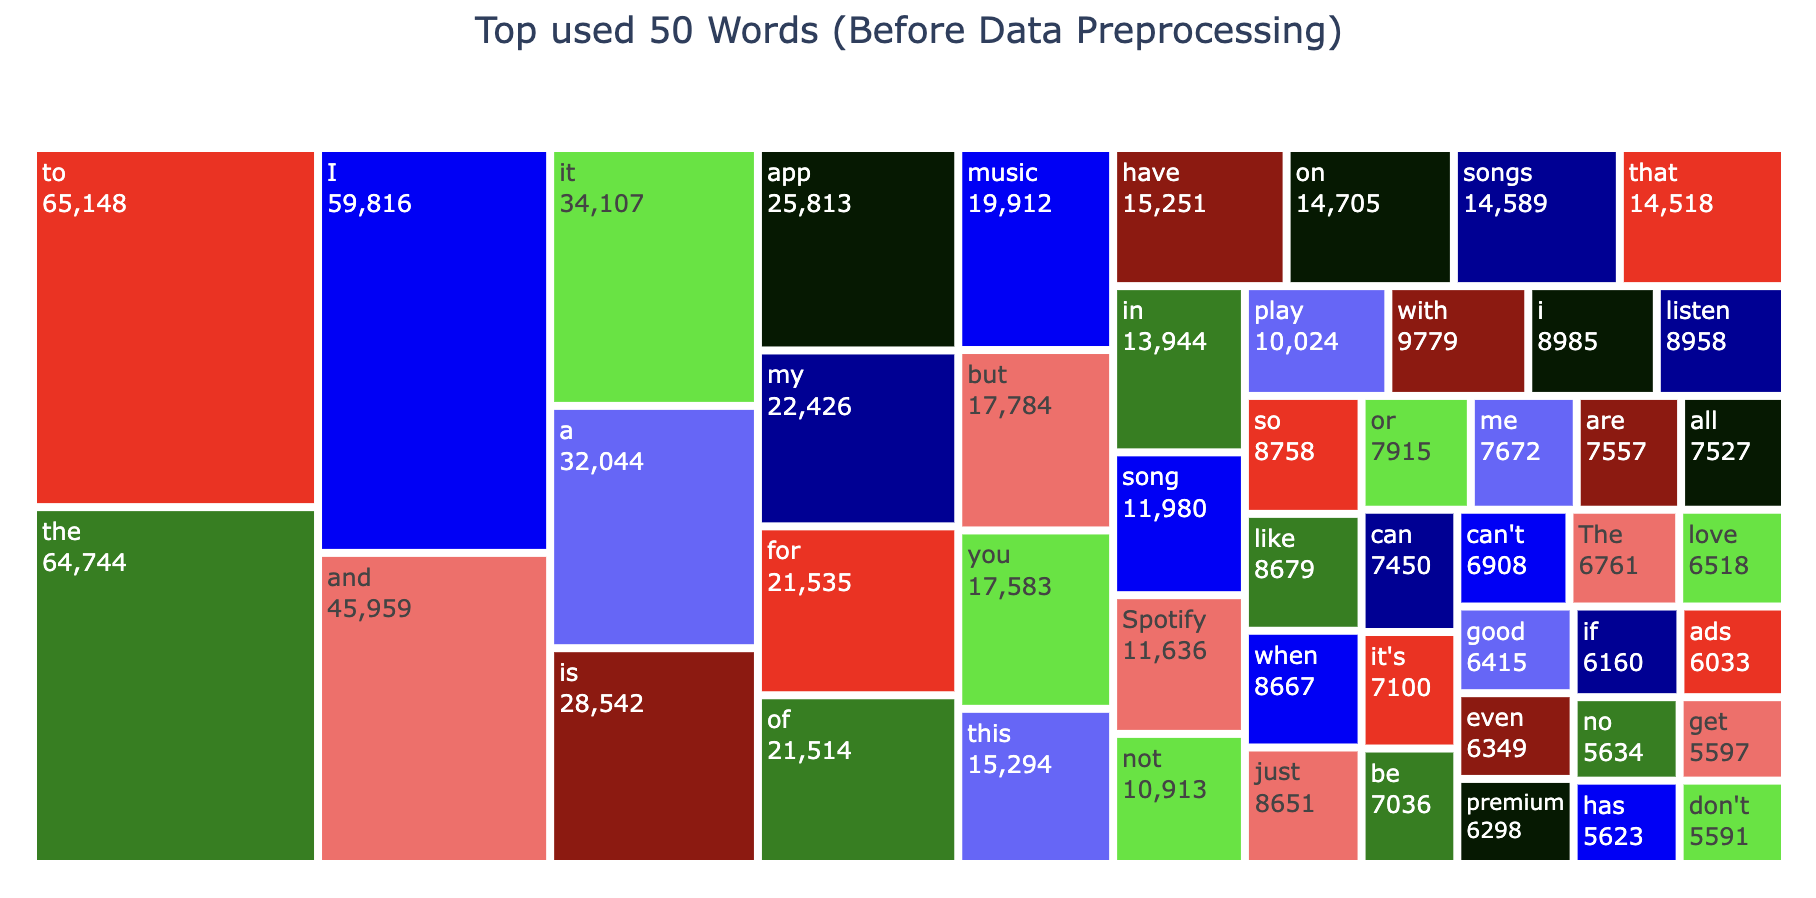

Plot above shows the top 50 words used inside of our app review

### 4.3 Count of Sentences and Words on Review

We want to know the length of tokenized word and tokenized sentence review before text processing

In [23]:
# Tokenize (Words and Sentences)

# Download punkt
nltk.download('punkt')

# Tokinze review to sentence and words
df_eda = df.copy()
df_eda['tokenized_sentences_length'] = df_eda['Review'].apply(lambda x: len(nltk.sent_tokenize(x)))
df_eda['tokenized_words_length'] = df_eda['Review'].apply(lambda x: len(nltk.word_tokenize(x)))
df_eda

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Review,Rating,tokenized_sentences_length,tokenized_words_length
0,"Great music service, the audio is high quality...",Good,2,24
1,Please ignore previous negative rating. This a...,Good,3,17
2,"This pop-up ""Get the best Spotify experience o...",Good,2,24
3,Really buggy and terrible to use as of recently,Bad,1,9
4,Dear Spotify why do I get songs that I didn't ...,Bad,2,26
...,...,...,...,...
61589,Even though it was communicated that lyrics fe...,Bad,3,53
61590,"Use to be sooo good back when I had it, and wh...",Bad,3,67
61591,This app would be good if not for it taking ov...,Bad,8,107
61592,The app is good hard to navigate and won't jus...,Bad,1,60


We have succesfully create new column to show the length of the tokenized review based on sentences and words. Next, we also would like to know the maximum and average length of the tokenized result

In [24]:
# Rating Sentiment Category
rating_cat = ['Good', 'Bad']

# Determining max and avg sentences length by each sentiment
print("Max and Average Sentences Length \n")
for i in rating_cat:
  print(f"Max sentence length in {i} Review \t = {df_eda[df_eda['Rating'] == i]['tokenized_sentences_length'].max()}")
  print(f"Avg sentence length in {i} Review \t = {df_eda[df_eda['Rating'] == i]['tokenized_sentences_length'].mean()}\n")

# Determining max and avg words length by each sentiment
print("-"*70)
print("Max and Average Words Length \n")
for i in rating_cat:
  print(f"Max word length in {i} Review \t = {df_eda[df_eda['Rating'] == i]['tokenized_words_length'].max()}")
  print(f"Avg word length in {i} Review \t = {df_eda[df_eda['Rating'] == i]['tokenized_words_length'].mean()}\n")

Max and Average Sentences Length 

Max sentence length in Good Review 	 = 21
Avg sentence length in Good Review 	 = 1.9567845270474464

Max sentence length in Bad Review 	 = 31
Avg sentence length in Bad Review 	 = 2.7121346324180693

----------------------------------------------------------------------
Max and Average Words Length 

Max word length in Good Review 	 = 299
Avg word length in Good Review 	 = 26.89694771834391

Max word length in Bad Review 	 = 796
Avg word length in Bad Review 	 = 42.620618752372515



It is obtained from the calculation above that **Bad Review tends to have more sentences and words length** compared with good review. It can be inferred that most of the customers who made bad review are more emotional in writing the review. Thus, producing longer sentences.

### 4.4 Sample Review on Each Sentiment Review


In this EDA, we would like to sample some of the review by each sentiments. This is perfomed to see the pattern on why customer reviewed our application as Good and Bad

In [25]:
# Print sample of good review
sample_good = df_eda[df_eda['Rating']=='Good'].sample()
print('Good Review 1')
print(sample_good.loc[:, 'Review'].values[0])

print('')

sample_good = df_eda[df_eda['Rating']=='Good'].sample()
print('Good Review 2')
print(sample_good.loc[:, 'Review'].values[0])

Good Review 1
i started using spotify in 2021, it has been non-stop amazing and its absolutly MENTAL how much i use it!

Good Review 2
Great service, free and paid. The app has a nice aesthetic and has few to no bugs. Works even on a slow net connection pretty smoothly. Happy premium user!


In [26]:
# Print sample of bad review
sample_bad = df_eda[df_eda['Rating']=='Bad'].sample()
print('Bad Review 1')
print(sample_bad.loc[:, 'Review'].values[0])

print('')

sample_bad = df_eda[df_eda['Rating']=='Bad'].sample()
print('Bad Review 2')
print(sample_bad.loc[:, 'Review'].values[0])

Bad Review 1
I been paid users have family plan for many years and lately this app crashes lot!! For price should be having problems with it.

Bad Review 2
Hey Spotify no means no! Stop playing songs I thumbed down. It won't stop playing stuff that I say I don't like. And it keeps forcing r&b on me even though I don't like r&b. It only seems to play top 100 but I can't get it to play anything I haven't heard too many times. Will not pick a genre no matter what genre I choose it just mixes all popular genres together It is not worth paying for It is worth paying to avoid because it will not play what you pay for. It's going to force top 100 on you.


From the samples above, it can be inferred that:
1. Good Review = Customer like the app and shows plus point of the app
2. Bad Review = Does not like something that the app offers or facing any problem with the apps

---

## 5. Data Preprocessing / Feature Engineering

The crucial part of NLP project is how well we are preprocessing the data to be fed into the model. Thus, in this section, we will be performing the preprocessing to solve the following issues:
1. Ambiguity
2. Coreference
3. Idioms
4. Context dependencies
5. Syntax / Grammar
6. Sarcasm

### Expanding Contractions

Expanding contraction is one of the biggest issue in NLP Preprocessing. Processing this will utilize **contraction** library that is available and being used within Data Scientist community.

In [27]:
# Def Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text) # From Contractions library

# Apply the contraction expansion to review column
df['text_processed'] = df['Review'].apply(expand_contractions)


### Text Processing

Text processing will be utilized to perform the following:
1. Case folding to lower case = lower case all words
2. Mention removal
3. Hashtag removal
4. Newline removal
5. Whitespace removal
6. URL Removal
7. Non-letter removal
8. Tokenization (word based) = will create token based on word
9. Stopword = using stopword english, since most of the review in english
10. Lemmetization = we will be using lemmetization since it produces more relevant words compared with stemming

In [28]:
# Define Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define Stopwords
stopword = set(stopwords.words('english'))
stopword.remove('not') # We dont want to remove 'not' since we already did contractions expanding

# Function for text processing
def text_preprocessing(text):
  '''
  Function to preprocess text including case folding, mention removal, hashtag removal,
  newline removal, whitespace removal, url removal, non-letter removal, tokenization,
  stopword removal, and lemmatization
  '''
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # Remove non-latin words from the sentences. There are some other language (chinese) in the reviews
  text = re.sub(r'[^\x00-\x7f]', r'', text)

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stopword]

  # Removing Words less than 2 lengths
  tokens =  [word for word in tokens if len(word) > 2]

 # Lemmatization
  tokens = [lemmatizer.lemmatize(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [29]:
# Apply the test processing function

df['text_processed'] = df['text_processed'].apply(lambda x: text_preprocessing(x))
df

,Review,Rating,text_processed
0,"Great music service, the audio is high quality...",Good,great music service audio high quality app eas...
1,Please ignore previous negative rating. This a...,Good,please ignore previous negative rating app sup...
2,"This pop-up ""Get the best Spotify experience o...",Good,pop get best spotify experience android annoyi...
3,Really buggy and terrible to use as of recently,Bad,really buggy terrible use recently
4,Dear Spotify why do I get songs that I didn't ...,Bad,dear spotify get song not put playlist shuffle...
...,...,...,...
61589,Even though it was communicated that lyrics fe...,Bad,even though communicated lyric feature availab...
61590,"Use to be sooo good back when I had it, and wh...",Bad,use sooo good back downloaded free version cou...
61591,This app would be good if not for it taking ov...,Bad,app would good not taking device start comp sp...
61592,The app is good hard to navigate and won't jus...,Bad,app good hard navigate not let play song click...


After text processing, we would like to know the words max and average length

In [30]:
# Rating Sentiment Category
rating_cat = ['Good', 'Bad']

# Tokinze review to sentence and words
df['tokenized_words_length'] = df['text_processed'].apply(lambda x: len(nltk.word_tokenize(x)))

# Determining max and avg words length by each sentiment
print("Max and Average Words Length \n")
for i in rating_cat:
  print(f"Max word length in {i} Review \t = {df[df['Rating'] == i]['tokenized_words_length'].max()}")
  print(f"Avg word length in {i} Review \t = {df[df['Rating'] == i]['tokenized_words_length'].mean()}\n")

Max and Average Words Length 

Max word length in Good Review 	 = 117
Avg word length in Good Review 	 = 12.252644303414929

Max word length in Bad Review 	 = 327
Avg word length in Bad Review 	 = 19.40712387700873



After text processing, the number of words is cut into half. This means that text processing is working well to reduce the number of unmeaningful words in the review

### Target Conversion

Next, we need to encode the target label (sentiment review) to number before modeling

In [31]:
# Encode / Change target to number

df['Label'] = df['Rating'].replace({'Good' : 1, 'Bad' : 0})
df

,Review,Rating,text_processed,tokenized_words_length,Label
0,"Great music service, the audio is high quality...",Good,great music service audio high quality app eas...,13,1
1,Please ignore previous negative rating. This a...,Good,please ignore previous negative rating app sup...,11,1
2,"This pop-up ""Get the best Spotify experience o...",Good,pop get best spotify experience android annoyi...,11,1
3,Really buggy and terrible to use as of recently,Bad,really buggy terrible use recently,5,0
4,Dear Spotify why do I get songs that I didn't ...,Bad,dear spotify get song not put playlist shuffle...,9,0
...,...,...,...,...,...
61589,Even though it was communicated that lyrics fe...,Bad,even though communicated lyric feature availab...,26,0
61590,"Use to be sooo good back when I had it, and wh...",Bad,use sooo good back downloaded free version cou...,29,0
61591,This app would be good if not for it taking ov...,Bad,app would good not taking device start comp sp...,45,0
61592,The app is good hard to navigate and won't jus...,Bad,app good hard navigate not let play song click...,26,0


In [32]:
df.Label.value_counts()

,count
Label,
0,31612
1,29781


Target is successfully encoded.

### Splitting the dataset

In [33]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.text_processed,
                                                    df["Label"],
                                                    test_size=0.15,
                                                    random_state=42,
                                                    stratify=df.Label)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=42,
                                                  stratify=y_train_val)

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (46965,)
Val Size   :  (5219,)
Test Size  :  (9209,)


After splitting, we have 46965 rows in our train-set, 5219 rows in our validation-set and 9209 rows in our test-set

### One-Hot Encoding the Label

We also require to encode our label, this will utilize one hot encoding

In [34]:
# Change Target to One Hot Encoding

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

### Text Vectorization

We need to initialize Text Vectorization for model layering. Text Vectorization is utilized to convert text data into a numerical representation that model can understand and process.  

We also setting the percentile of 10% of words that will be used in the model. We will train the model that is in the range of percentile 10% - 90% (cutoff of 10%). Resulting for our model to only train words that have high significance

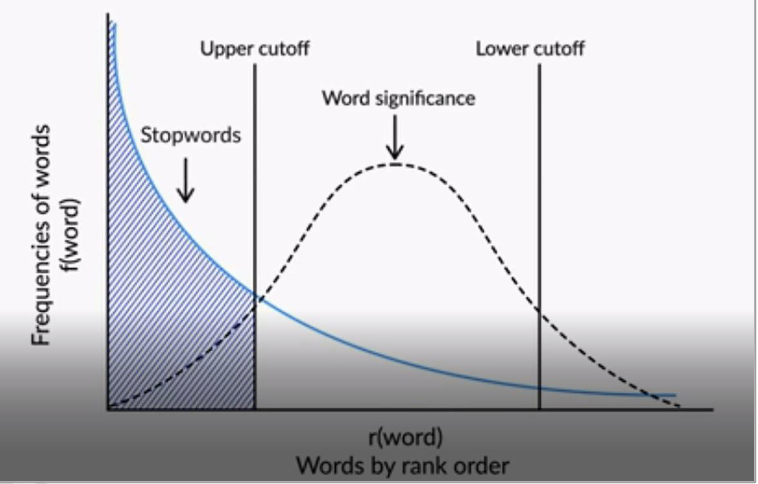

In [35]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform
X_train_vec = vectorizer.fit_transform(X_train)

# Convert to DataFrame
term_freq = pd.DataFrame(X_train_vec.toarray(), columns=vectorizer.get_feature_names_out())

# Sum term frequencies
term_counts = term_freq.sum(axis=0)

# Convert to series type
term_counts = pd.Series(term_counts, index=term_freq.columns)

# Calculate percentiles as specified 10% and 90%
lower_percentile = term_counts.quantile(0.1)
upper_percentile = term_counts.quantile(0.9)

# Applying the cutoffs
filtered_terms = term_counts[(term_counts >= lower_percentile) & (term_counts <= upper_percentile)]

# Get the filtered feature names after applying the cutoff
filtered_feature_names = filtered_terms.index

# Initialize CountVectorizer using the filtered vocabulary
vectorizer_filtered = CountVectorizer(vocabulary=filtered_feature_names)

# Final Transform data with new vectorizer
X_Train_filtered = vectorizer_filtered.fit_transform(X_train)
X_test_filtered = vectorizer_filtered.transform(X_test)

In [36]:
# Finding the Number of Vocabs and Max Token Length in One Document

total_vocab = len(vectorizer_filtered.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  15910
Maximum Sentence Length :  327 tokens


We have a total of 15949 vocab with max setence length of 325 tokens inside of our dataset

In [37]:
# Text Vectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

text_vectorization.adapt(X_train)

Displaying the top 10 of tokens

In [38]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'not',
 'app',
 'song',
 'music',
 'spotify',
 'play',
 'playlist',
 'like',
 'listen',
 'premium',
 'love',
 'good',
 'ad',
 'great',
 'even',
 'want',
 'time',
 'get']

Above are the list of most used tokens inside the dataset

### Word Embedding

Word Embedding is one of the powerful tools in data preprocessing before model training. Embedding will represents words for text analysis in the form of real-valued vectors

In [39]:
# Word Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=64,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)
embedding

### Exploratory Data Analysis (EDA) After Data Preprocessing

After we have completed the Data Preprocessing, we would like to know the the vocab/words presented in our review.

First, we want to know which vocab are incorporated inside the Bad Review

In [40]:
# Define variable and query Bad Sentiment Review
bad_sentiment = df[df['Rating']=='Bad']
bad_sentiment

,Review,Rating,text_processed,tokenized_words_length,Label
3,Really buggy and terrible to use as of recently,Bad,really buggy terrible use recently,5,0
4,Dear Spotify why do I get songs that I didn't ...,Bad,dear spotify get song not put playlist shuffle...,9,0
5,The player controls sometimes disappear for no...,Bad,player control sometimes disappear reason app ...,11,0
7,Still extremely slow when changing storage to ...,Bad,still extremely slow changing storage external...,34,0
9,"I'm deleting this app, for the following reaso...",Bad,deleting app following reason app failing busi...,37,0
...,...,...,...,...,...
61588,Back to one frkng star. First of all there's t...,Bad,back one frkng star first spotify trying play ...,44,0
61589,Even though it was communicated that lyrics fe...,Bad,even though communicated lyric feature availab...,26,0
61590,"Use to be sooo good back when I had it, and wh...",Bad,use sooo good back downloaded free version cou...,29,0
61591,This app would be good if not for it taking ov...,Bad,app would good not taking device start comp sp...,45,0


In [41]:
# Displaying top 50 most used words for Bad Review (After text processing)

FreqOfWords_Bad = bad_sentiment['text_processed'].str.split(expand=True).stack().value_counts()
FreqOfWords_Bad_top50 = FreqOfWords_Bad[:50]

fig = px.treemap(FreqOfWords_Bad_top50, path=[FreqOfWords_Bad_top50.index], values=FreqOfWords_Bad_top50)
fig.update_layout(title_text='Top used 50 Words for Bad Sentiment',
                  title_x=0.5, title_font=dict(size=18),
                  treemapcolorway = ['red', 'green', 'blue']
                  )
fig.update_traces(textinfo="label+value")
fig.show()

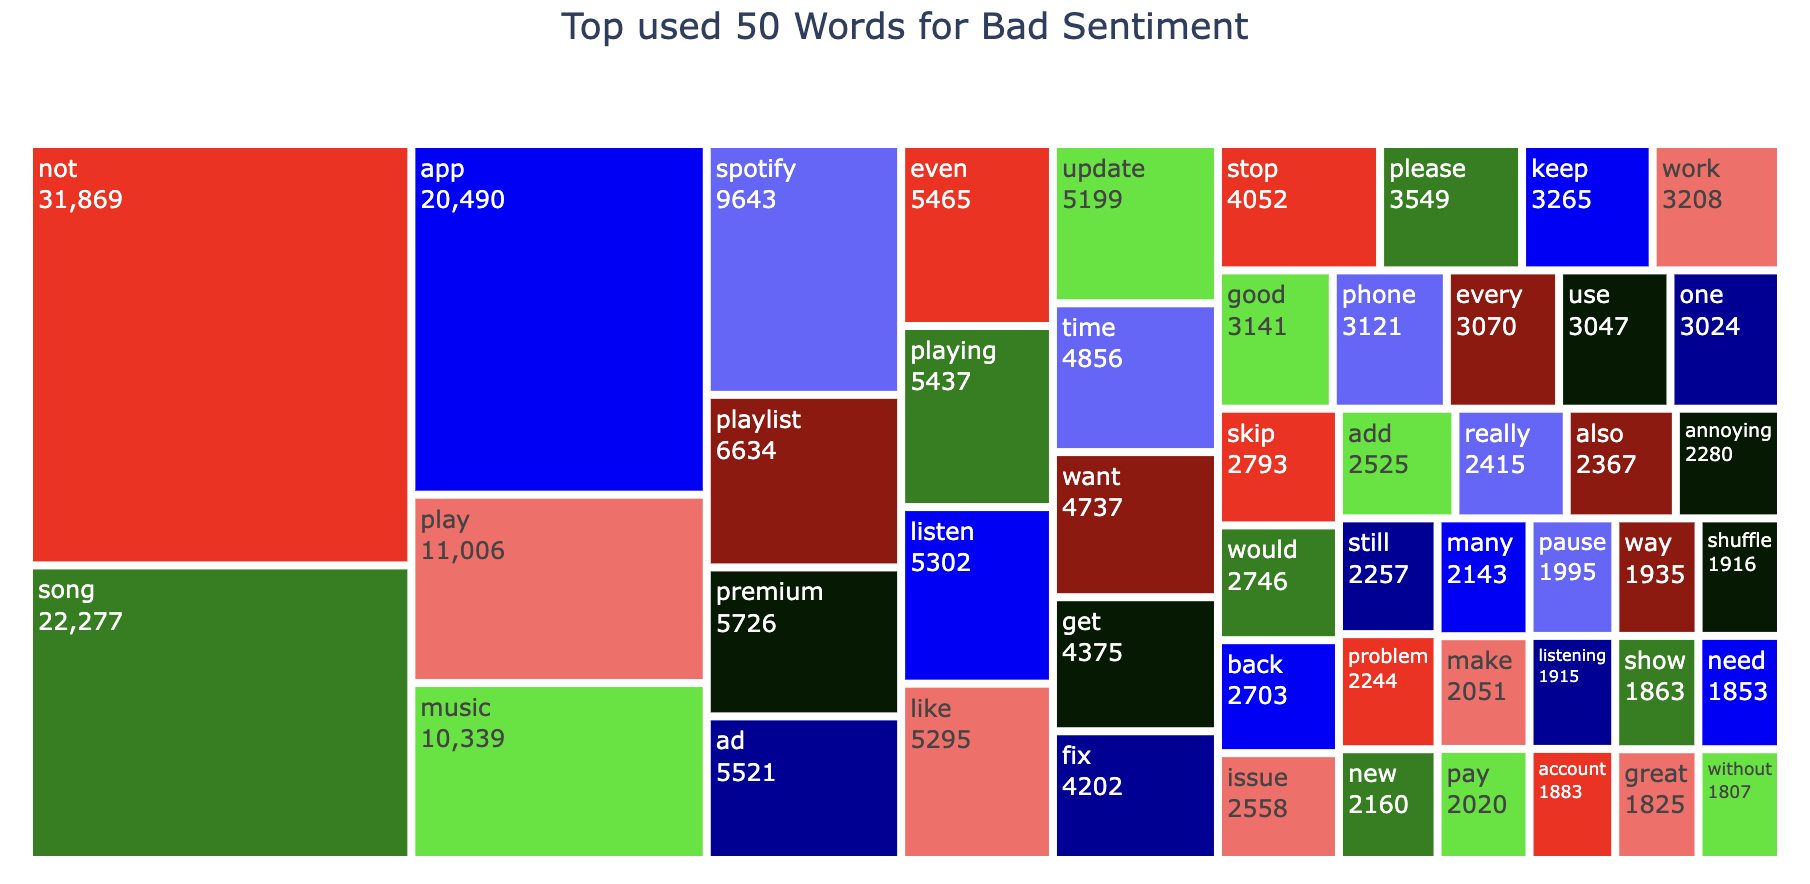

From the figure above, it can be seen that most of bad review is about complaining. It consist of words such as "not", "problem", "fix", "issue", and etc of similar complaining words

After that, we also want to know what are the vocab/words that are incorporated inside the Good Review

In [42]:
# Define variable to query Bad Sentiment Review
good_sentiment = df[df['Rating']=='Good']
good_sentiment

,Review,Rating,text_processed,tokenized_words_length,Label
0,"Great music service, the audio is high quality...",Good,great music service audio high quality app eas...,13,1
1,Please ignore previous negative rating. This a...,Good,please ignore previous negative rating app sup...,11,1
2,"This pop-up ""Get the best Spotify experience o...",Good,pop get best spotify experience android annoyi...,11,1
6,I love the selection and the lyrics are provid...,Good,love selection lyric provided song listening,6,1
8,It's a great app and the best mp3 music app I ...,Good,great app best music app ever used one problem...,19,1
...,...,...,...,...,...
61579,I've been using Spotify for about 3+ years now...,Good,using spotify year love music app negative thi...,33,1
61580,the only star Spotify doesn't get is the fact ...,Good,star spotify not get fact not download individ...,11,1
61581,This app has remixes from Music Artist that I'...,Good,app remixes music artist listening couple deca...,18,1
61582,It selects music based on your taste makes bes...,Good,selects music based taste make best mix tape m...,15,1


In [43]:
# Displaying top 50 most used words of Good Review (After text processing)

FreqOfWords_Good = good_sentiment['text_processed'].str.split(expand=True).stack().value_counts()
FreqOfWords_Good_top50 = FreqOfWords_Good[:50]

fig = px.treemap(FreqOfWords_Good_top50, path=[FreqOfWords_Good_top50.index], values=FreqOfWords_Good_top50)
fig.update_layout(title_text='Top used 50 Words for Good Sentiment',
                  title_x=0.5, title_font=dict(size=18),
                  treemapcolorway = ['red', 'green', 'blue']
                  )
fig.update_traces(textinfo="label+value")
fig.show()

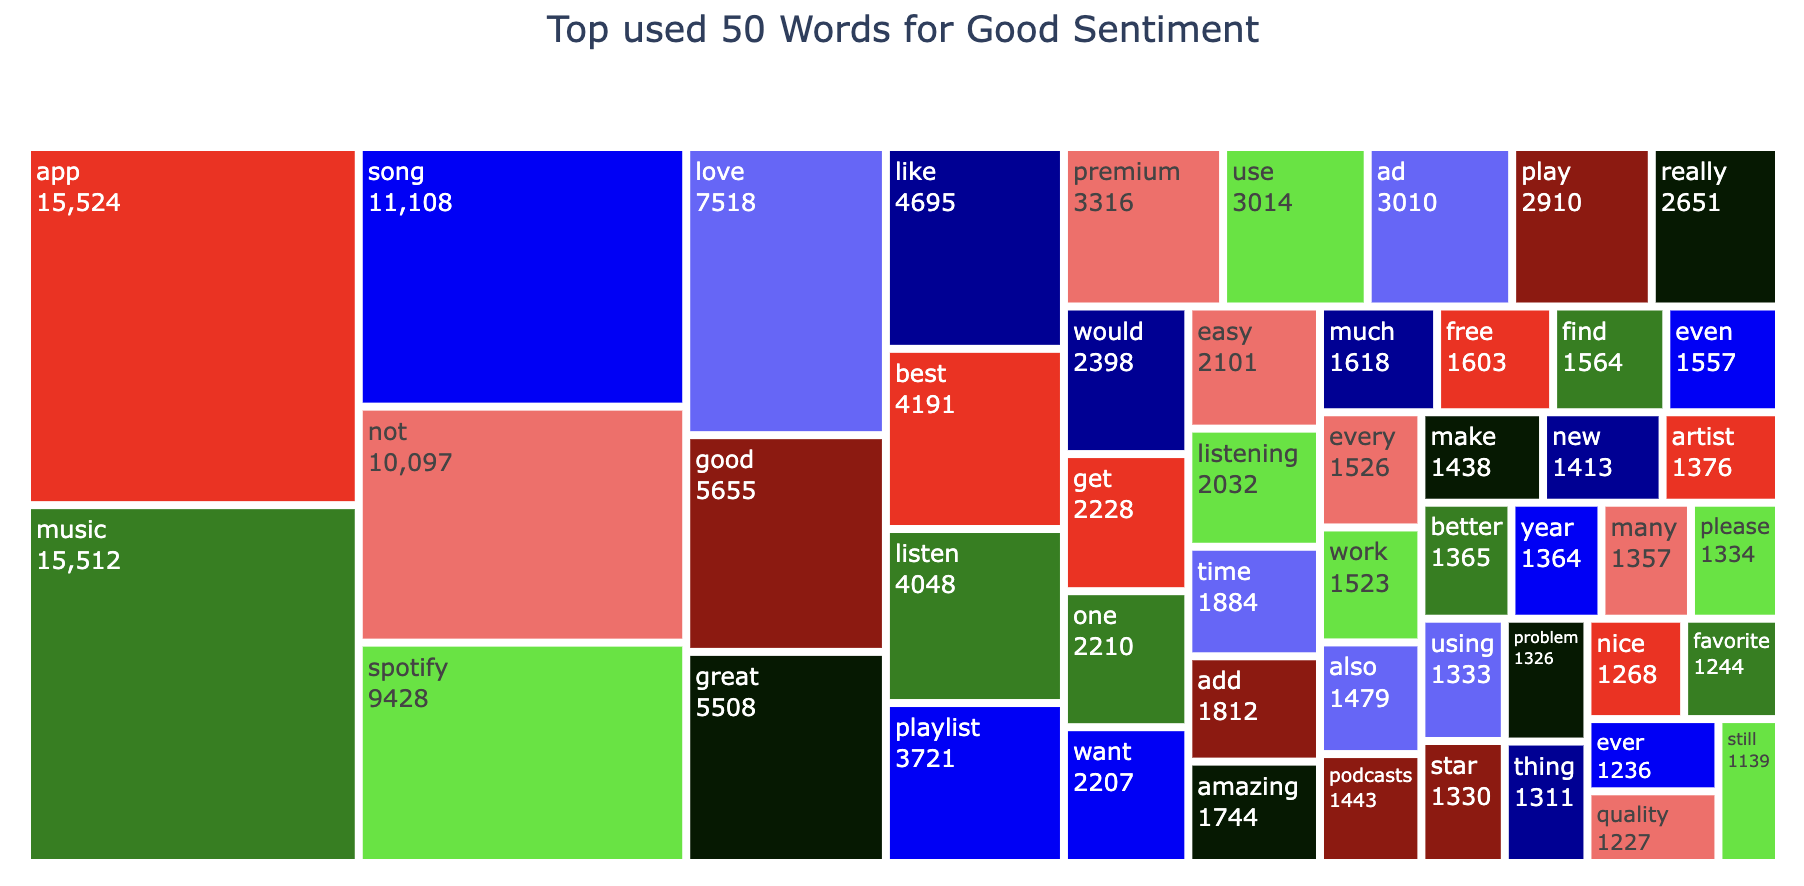

The words/vocab inside the good review is incorporated with the customer satisfaction about the app. Words such as "good", "best", "love", "amazing", and etc are presented in this section

---

## ANN Modeling

For the Artificial Neural Network (ANN) Modelling, we will try to train ***2 models***. This will include:

1. ***Baseline model***, to see how the basic model of NLP can understand our data.
2. ***Improvement model***, in this model we will utilize other hyperparameter and methods including normalization, dropout, and regularization to prevent overfitting

Evaluation for this model will consider the accuracy metrics, since We want the model to **identify** correctly the type of sentiment of the review made by the customer (Good or Bad Sentiment).


## 6. ANN Training Baseline

This section will perform baseline ANN model to process the data. This section will include baseline model definition, model training, and evaluation of the model

### 6.1 Model Definition (Baseline)

This model will use sequential API ANN. Further, there will be text vectorization layer, embedding layer, 2 hidden layer, and an output layer will be used in this model.

Layers:
1. ***Text Vectorization Layer*** = As introduced in the feature engineering section. Will use percentile method in the count vector, hyperparameter of max_input = total vocab and output sequence length = max length of the sentence in the dataset

2. ***Embedding Layer*** = Layer after the text vectorization, with hyperparameter of giving output dim 64

3. ***Hidden Layer 1*** = Using LSTM method (most common in NLP processing model), 16 neurons and glorotuniform initializer.

4. ***Hidden Layer 2*** = Same parameter with Hidden Layer 1, but reducing the number of neurons into half.

5. ***Output Layer*** = 2 Neurons as we will have 2 output of binary class, dense matriks with softmax activation.

In [44]:
# Model Training using LSTM
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define Model (Sequential API)
model_1 = Sequential()

# Text Vectorization Layer
model_1.add(text_vectorization)

# Embedding Layer
model_1.add(embedding)

# Hidden Layer 1
model_1.add((LSTM(16, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))

# Hidden Layer 2
model_1.add((LSTM(8, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))

# Output Layer
model_1.add(Dense(2, activation='softmax'))

# Model compiling
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


CPU times: user 634 ms, sys: 9.65 ms, total: 643 ms
Wall time: 787 ms


### 6.2 Model Training

This section will perform the baseline model training. Using 20 epochs will be executed in this model, since 20 epochs already show the tendency for the model to learn the data in this dataset.

In [45]:
%%time
# Model Training
model_1_hist = model_1.fit(X_train, y_train_ohe, epochs=20, validation_data=(X_val, y_val_ohe))

Epoch 1/20
1468/1468 [==============================] - 63s 40ms/step - loss: 0.6930 - accuracy: 0.5121 - val_loss: 0.6927 - val_accuracy: 0.5148
Epoch 2/20
1468/1468 [==============================] - 33s 23ms/step - loss: 0.6928 - accuracy: 0.5143 - val_loss: 0.6928 - val_accuracy: 0.5148
Epoch 3/20
1468/1468 [==============================] - 33s 23ms/step - loss: 0.6928 - accuracy: 0.5149 - val_loss: 0.6928 - val_accuracy: 0.5148
Epoch 4/20
1468/1468 [==============================] - 33s 22ms/step - loss: 0.6928 - accuracy: 0.5149 - val_loss: 0.6928 - val_accuracy: 0.5148
Epoch 5/20
1468/1468 [==============================] - 33s 22ms/step - loss: 0.6928 - accuracy: 0.5149 - val_loss: 0.6927 - val_accuracy: 0.5148
Epoch 6/20
1468/1468 [==============================] - 33s 22ms/step - loss: 0.6928 - accuracy: 0.5149 - val_loss: 0.6929 - val_accuracy: 0.5148
Epoch 7/20
1468/1468 [==============================] - 33s 22ms/step - loss: 0.6928 - accuracy: 0.5149 - val_loss: 0.6928 -

Plotting the accuracy and loss from the model training

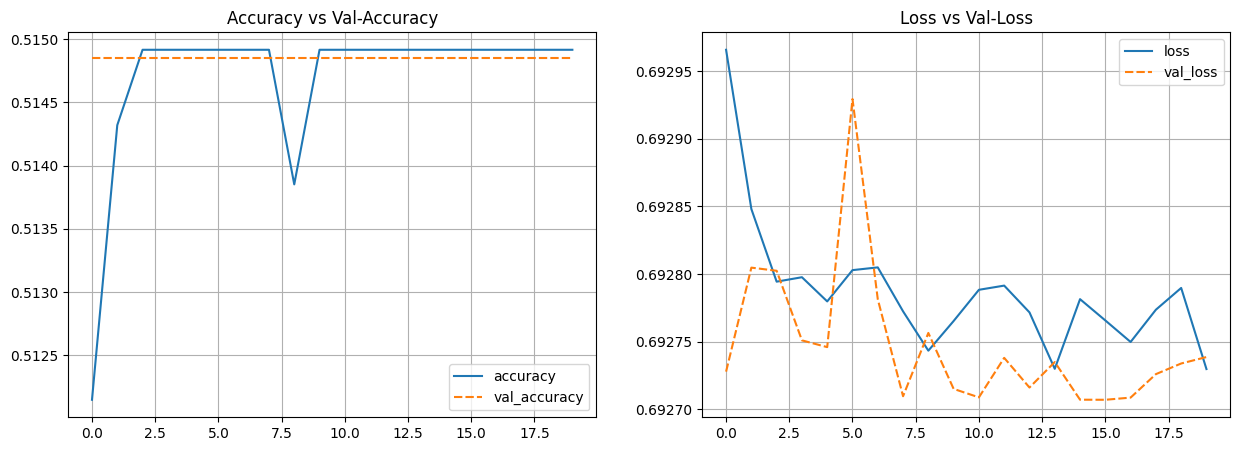

In [46]:
# Plot Training Results

model_1_hist_df = pd.DataFrame(model_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### 6.3 Model Evaluation

From the graph of accuracy and loss above, it is clearly shown that our base model is failed to understand the data. It shows no significant pattern in the accuracy graph for the train-set and no pattern at all in the validation-set. Furthermore, the learning curve shows that the model is failed to learn the model which gives fluctuating loss value for both train and validation-set.

Furthermore, we will evaluate the model using classification report.

In [47]:
# Base Model Evaluation of Train-set
y_pred_model1_train = np.argmax(model_1.predict(X_train), axis=-1)

print(classification_report(y_train, y_pred_model1_train, zero_division=1))

1468/1468 [==============================] - 15s 9ms/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.68     24183
           1       1.00      0.00      0.00     22782

    accuracy                           0.51     46965
   macro avg       0.76      0.50      0.34     46965
weighted avg       0.75      0.51      0.35     46965



In [48]:
# Model Evaluation of test-set
y_pred_model2_test = np.argmax(model_1.predict(X_test), axis=-1)

print(classification_report(y_test, y_pred_model2_test, zero_division=1))

288/288 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.51      1.00      0.68      4742
           1       1.00      0.00      0.00      4467

    accuracy                           0.51      9209
   macro avg       0.76      0.50      0.34      9209
weighted avg       0.75      0.51      0.35      9209



From the classification report, we can see that our base model is underfit with only 51% of accuracy both on validation and train set (Underfit). Thus, model improvement will be performed in the next section.

## 7. ANN Model Improvement

Model improvement will be performed to create a better and more reliable model rather than the previous model. Overall, layers included in the model improvement are as follows:  
1. Sequential Model Definition
2. Text Vectorization Layer
3. Embedding Layer
4. Hidden Layer 1
5. Hidden Layer 2
6. Output Layer

***Several improvement*** performed including:
1. Hyperparameter regularizer 'l2' in embedding layer to prevent overfitting.
2. Dropout and BatchNormalization after embedding layer. This will be done to prevent overfitting and faster training time.
3. Using BiDirectional to 2 hidden layer. This will ensure the model to train neural networks that process input data in both the forward and backward directions.
4. Using regularization l2 at 2 hidden layers to prevent overfitting
5. Adding dropout and layerNormalization after both hidden layer to prevent overfitting.
6. Schedule transfer learning, to change the learning rate of the model overtime and resulting a better learning rate.

### 7.1 Model Definition

In [49]:
# Model Improvement
%%time

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define Model
model_2 = Sequential()

# Text Vectorization Layer
model_2.add(text_vectorization)

# Embedding Layer
model_2.add(Embedding(input_dim=total_vocab,
                      output_dim=64,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len,
                      embeddings_regularizer=regularizers.l2(0.01)))

model_2.add(Dropout(0.1))             # Dropout Embedding Layer
model_2.add(BatchNormalization())     # Normalization Embedding Layer

# Hidden Layer 1
model_2.add(Bidirectional(LSTM(8, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed), kernel_regularizer='l2')))
model_2.add(Dropout(0.3))             # Dropout Hidden Layer 1
model_2.add(LayerNormalization())     # Normalization Hidden Layer 1

# Hidden Layer 2
model_2.add(Bidirectional(LSTM(4, kernel_initializer=tf.keras.initializers.GlorotUniform(seed), kernel_regularizer='l2')))
model_2.add(Dropout(0.2))             # Dropout Hidden Layer 2
model_2.add(LayerNormalization())     # Normalization Hidden Layer 2

# Output Layer
model_2.add(Dense(2, activation='softmax'))


# Schedule Learning Rate
lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)


# Model Compiling
model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 327)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 327, 64)           1018240   
                                                                 
 dropout (Dropout)           (None, 327, 64)           0         
                                                                 
 batch_normalization (Batch  (None, 327, 64)           256       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 327, 16)           4672      
 al)                                                             
                                                        

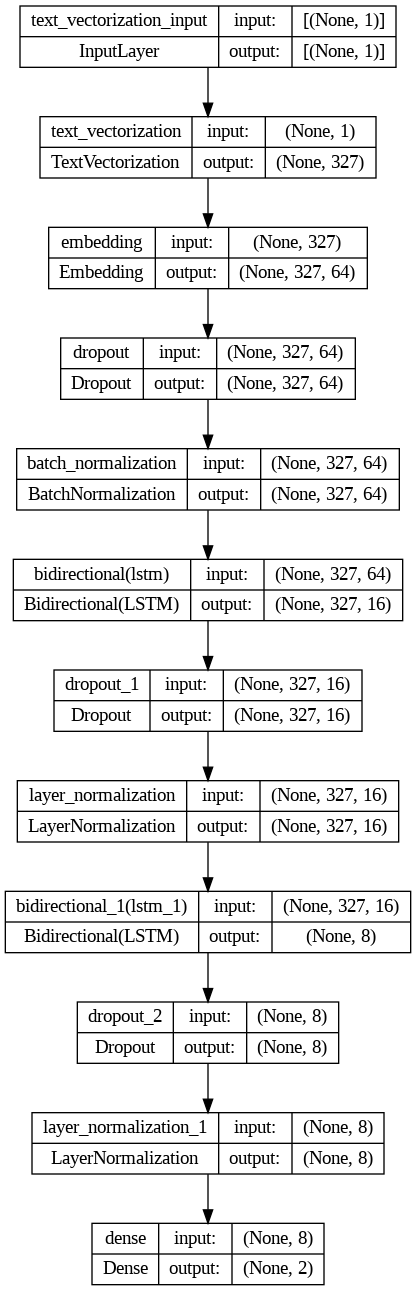

In [50]:
# Plot Layers
tf.keras.utils.plot_model(model_2, show_shapes=True)

### 7.2 Model Improvement Training

In [51]:
# Model Training
%%time
model_2_hist = model_2.fit(X_train, y_train_ohe, epochs=30, validation_data=(X_val, y_val_ohe))

Epoch 1/30
1468/1468 [==============================] - 71s 43ms/step - loss: 0.8239 - accuracy: 0.8273 - val_loss: 0.5089 - val_accuracy: 0.8601
Epoch 2/30
1468/1468 [==============================] - 61s 42ms/step - loss: 0.4957 - accuracy: 0.8469 - val_loss: 0.4415 - val_accuracy: 0.8586
Epoch 3/30
1468/1468 [==============================] - 61s 42ms/step - loss: 0.4562 - accuracy: 0.8485 - val_loss: 0.4272 - val_accuracy: 0.8622
Epoch 4/30
1468/1468 [==============================] - 63s 43ms/step - loss: 0.4393 - accuracy: 0.8519 - val_loss: 0.4186 - val_accuracy: 0.8634
Epoch 5/30
1468/1468 [==============================] - 62s 42ms/step - loss: 0.4274 - accuracy: 0.8545 - val_loss: 0.4012 - val_accuracy: 0.8647
Epoch 6/30
1468/1468 [==============================] - 62s 42ms/step - loss: 0.4159 - accuracy: 0.8580 - val_loss: 0.4030 - val_accuracy: 0.8647
Epoch 7/30
1468/1468 [==============================] - 61s 42ms/step - loss: 0.4095 - accuracy: 0.8579 - val_loss: 0.3911 -

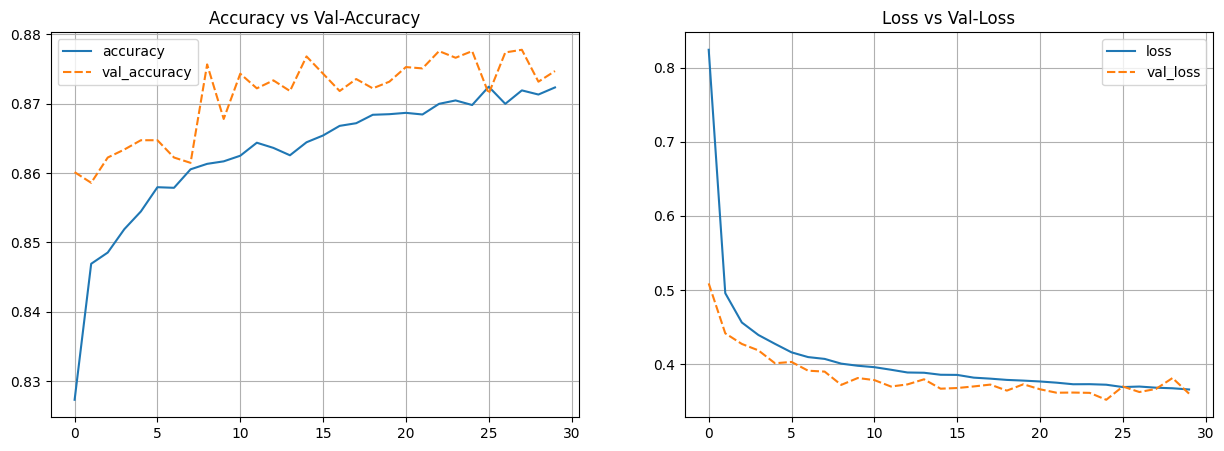

In [52]:
# Plot Training Results

model_2_hist_df = pd.DataFrame(model_2_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_2_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_2_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

### 7.3 Model Improvement Evaluation

From the accuracy graph and learning curve graph above. This improved model show a ***good-fit*** model with accuracy on the train and validation set at around 0.865. Additionally the learning curve is very similar between the train-set and validation-set, proving a ***good-fit model*** with loss value less than 0.4

We also want to compare the classification report, specifically we want to know the model accuracy in predicting the train-set and test-set.

In [53]:
# Model Evaluation of train-set
y_pred_model2_train = np.argmax(model_2.predict(X_train), axis=-1)

print(classification_report(y_train, y_pred_model2_train))

1468/1468 [==============================] - 27s 18ms/step
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     24183
           1       0.91      0.87      0.89     22782

    accuracy                           0.90     46965
   macro avg       0.90      0.90      0.90     46965
weighted avg       0.90      0.90      0.90     46965



In [54]:
# Model Evaluation of test-set
y_pred_model2 = np.argmax(model_2.predict(X_test), axis=-1)

print(classification_report(y_test, y_pred_model2))

288/288 [==============================] - 5s 18ms/step
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4742
           1       0.88      0.86      0.87      4467

    accuracy                           0.88      9209
   macro avg       0.88      0.88      0.88      9209
weighted avg       0.88      0.88      0.88      9209



From the classification report, we can see that the model improvement is considered as a ***good-fit*** model. We have achieved an accuracy of 0.9 in the train-set and accuracy of 0.88 in the test-set compared with only 0.51 accuracy from the base model.

Summary:

| Parameter     | Base Model | Improved Model|
| ----------- | ----------- |----------- |
| Train-set   | 0.51 | 0.9     |
| Test-set  | 0.51 | 0.88    |

### Plus and Minus Point of the Model

Plus and Minus Model will be evaluated in this section.

Plus Model = Where the model is predicting correctly.  
Minus Model = Where the model is miss to predict

First, we need to combine the prediction with the original dataframe

In [55]:
# Create new concat dataframe pred with original dataframe
eval_df = pd.DataFrame({
            'actual' : y_test,
            'prediction' : np.ndarray.flatten(y_pred_model2)
})
eval = pd.concat([pd.DataFrame(X_test), eval_df],axis=1)
eval

,text_processed,actual,prediction
43222,like listen different genre music anytime add ...,1,1
2735,app awesome really recommend people really goo...,1,1
12078,really good selection ad not bad actually get ...,1,1
4632,app great streaming music gotten habit closing...,0,0
44423,love service absolutely hate app freeze shuts ...,0,0
...,...,...,...
41419,app still garbage player not show freeze one s...,0,0
7414,many commercial dang commercial get minute mus...,0,0
1093,enjoy listening christian favorite song,1,1
49076,comment regarding lack bluetooth connectivity ...,0,0


#### Model Minus Point (FN)

In [56]:
# Model Minus Point (FN)
minus_model = eval[(eval['actual']==1) &(eval['prediction']==0)]
minus_model

,text_processed,actual,prediction
37699,glitching bar show playing disappearing,1,0
40902,must say one best market good song collection ...,1,0
57495,happened lyric feature not showing latest vers...,1,0
31476,pay premium also kind fix glitch,1,0
15441,app keep crashing press play play button new u...,1,0
...,...,...,...
32686,problem far unnecessary ad please fix,1,0
55661,app working perfectly not search come empty yet,1,0
37164,love spotify get irritated play song even half...,1,0
14871,not give start not move song like pretty savag...,1,0


In [57]:
# Displaying top 10 most used words that gives us wrong prediction

FreqOfWords_minus = minus_model['text_processed'].str.split(expand=True).stack().value_counts()
FreqOfWords_minus_top10 = FreqOfWords_minus[:10]

fig = px.treemap(FreqOfWords_minus_top10, path=[FreqOfWords_minus_top10.index], values=FreqOfWords_minus_top10)
fig.update_layout(title_text='Top used 10 Words that gives us wrong prediction',
                  title_x=0.5, title_font=dict(size=18),
                  treemapcolorway = ['red', 'green', 'blue']
                  )
fig.update_traces(textinfo="label+value")
fig.show()

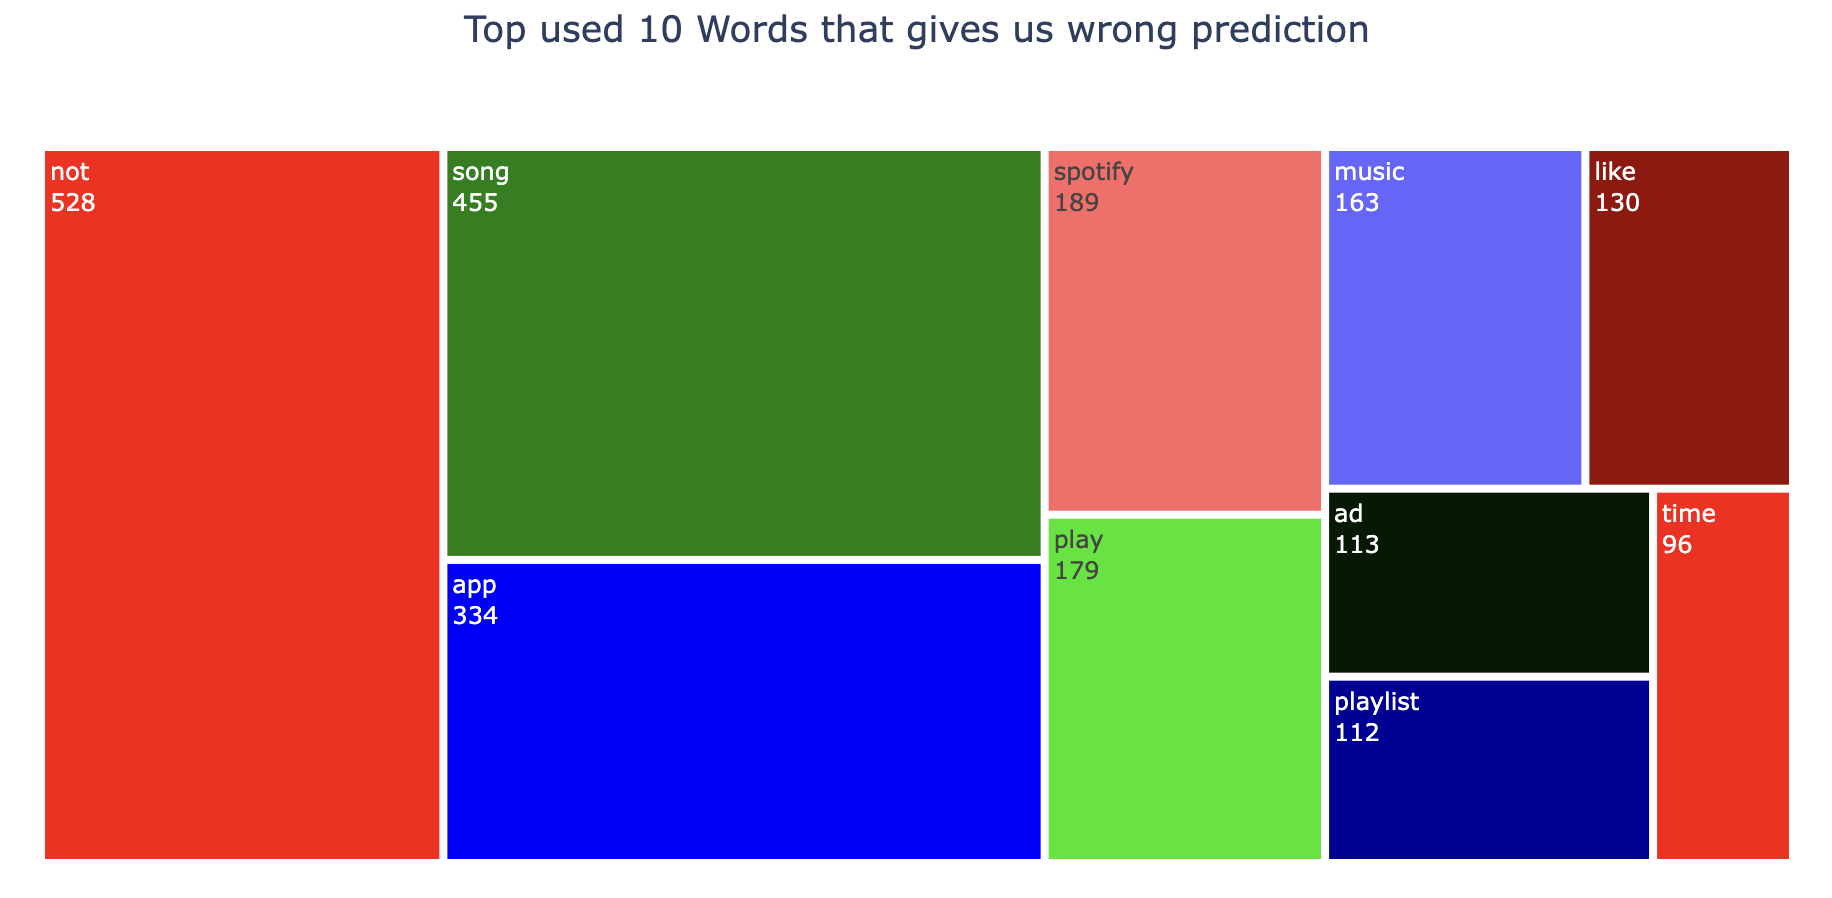

Our model are more likely to miss predicting if the review is incorporated with the words above. Most of the bad review are consist of word "not". Thus, the chance to miss predict review that include "not" vocab is high.

#### Plus Point

Check where our model is predicting correctly (TP)

In [58]:
# Query through where predicting is correct (TP)
plus_model = eval[(eval['actual']==1) &(eval['prediction']==1)]

In [59]:
# Displaying top 10 most used words that gives us corret prediction

FreqOfWords_plus = plus_model['text_processed'].str.split(expand=True).stack().value_counts()
FreqOfWords_plus_top10 = FreqOfWords_plus[:10]

fig = px.treemap(FreqOfWords_plus_top10, path=[FreqOfWords_plus_top10.index], values=FreqOfWords_plus_top10)
fig.update_layout(title_text='Top used 10 Words that gives us correct prediction',
                  title_x=0.5, title_font=dict(size=18),
                  treemapcolorway = ['red', 'green', 'blue']
                  )
fig.update_traces(textinfo="label+value")
fig.show()

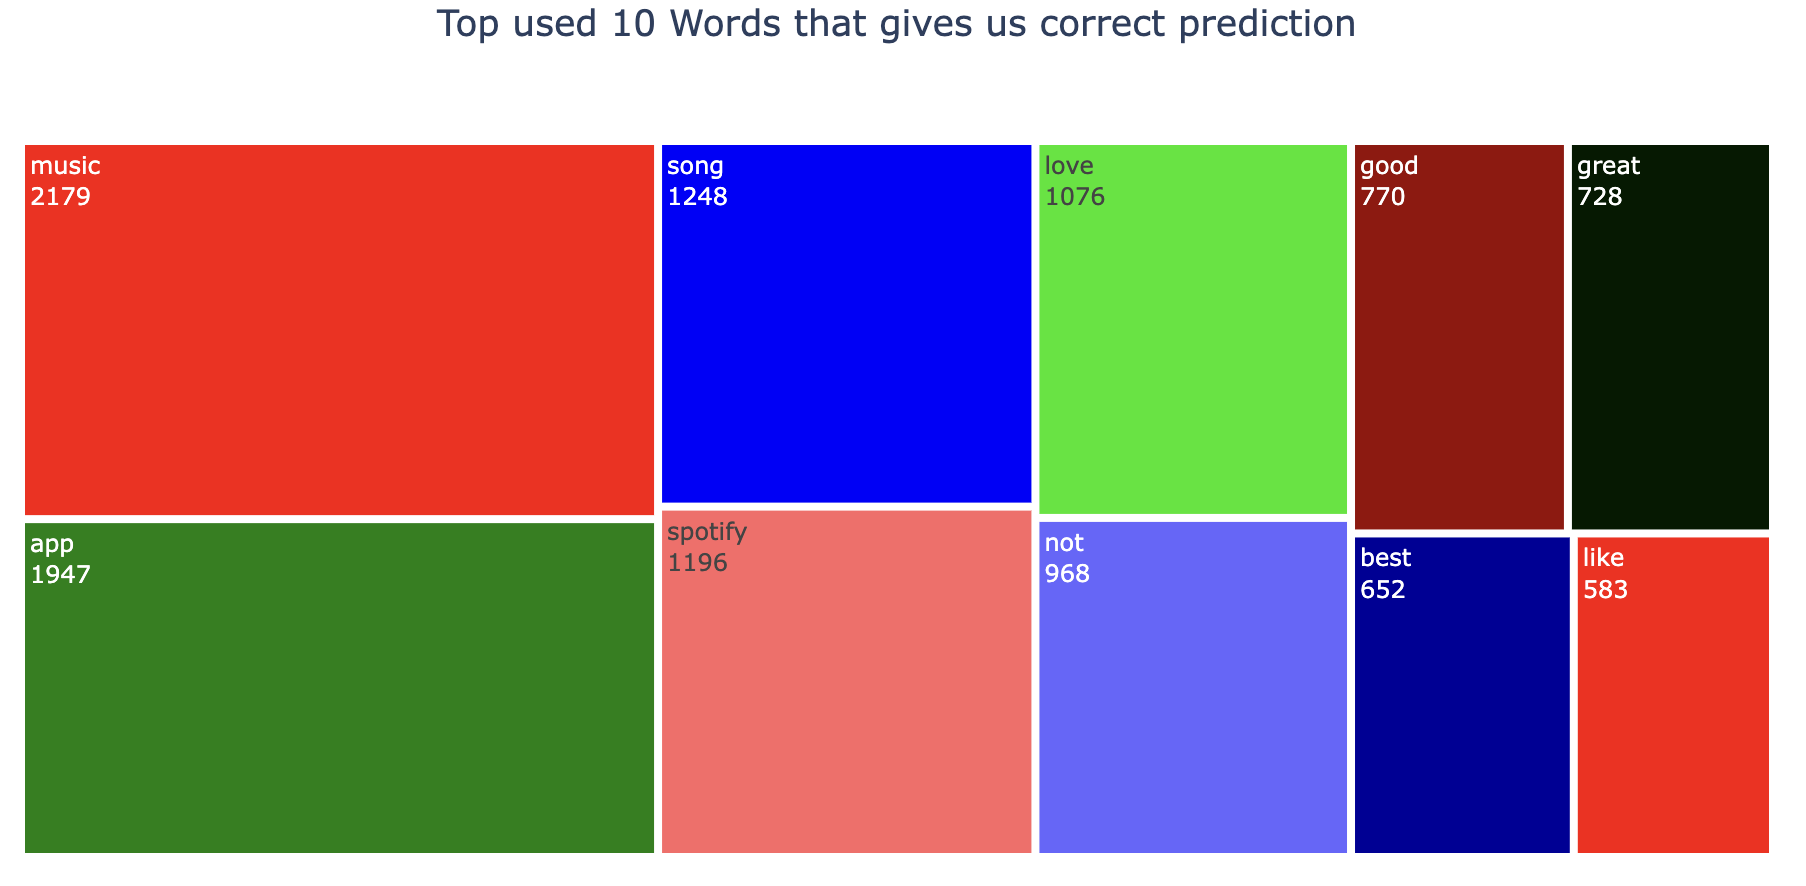

Our model can predict best if the review incorporated with the above words. Top 3 words the model can correctly predict are 'music', 'app', and 'song'.

---

## 8. Model Saving

We will save the best model (improvement model) that will be used for inference and predicting the review sentiment

In [60]:
# Saving Best Model
model_2.save('model_final')


In [ ]:
!zip -r model_final.zip model_final
from google.colab import files
files.download('model_final.zip')

---

## 9. Model Inference

Inference of the model will be done in separated notebook

---

## 10. Conclusion

The metric that will be focused for evaluating model is **Accuracy**. We want the model to **identify** correctly the type of sentiment of the review made by the customer.

Understanding the data is very important for our app improvement, where we are able to find out which are the good and bad topic about our application

***Exploratory Data Analysis:***
- Balance review of Bad Review and Good Review
- Most of the words/token inside the bad review is about complaining. It consist of words such as "not", "problem", "fix", "issue", and etc of similar complaining words
- Words/token inside the good review is incorporated with the customer satisfaction about the app. Words such as "good", "best", "love", "amazing", and etc are presented in this section
- Text processing reduce half of the token compared with raw data

***Based on what we have done in this notebook, it can be concluded that:***
1. Baseline model with 2 LSTM Hidden layer failed to understand our Data
2. Further parameter tuning and adding more method in the  **improved model have achieved a good-fit model and ready to be deployed**.

Base and Improved Model Accuracy:

| Parameter     | Base Model | Improved Model|
| ----------- | ----------- |----------- |
| Train-set   | 0.51 | 0.9     |
| Test-set  | 0.51 | 0.88    |

***Key improvement/changes in the model improvement:***
1. Hyperparameter regularizer 'L2' in embedding layer to prevent overfitting.
2. Dropout and BatchNormalization after embedding layer. This performed to prevent overfitting and faster training time.
3. Using BiDirectional for 2 hidden layer. This will ensure the model to train neural networks that process input data in both the forward and backward directions.
4. Using regularization L2 at 2 hidden layers to prevent overfitting
5. Adding dropout and layerNormalization after both hidden layer to prevent overfitting.
6. Schedule transfer learning, to change the learning rate of the model overtime and resulting a better learning rate.

***Business Recommendation:***  
  
As the model is a good-fit and well predicting the sentiment from review. The business recommendation are in the following:
- Focus more on Bad Sentiment/Topic and address the issues. Some of the Bad Review includes words "bug", "annoying", "issue", "fix", etc. This indicates several problem in application need to be addressed.

***Further Improvement:***
- Different method of text preprocessing
- Adding more stopword
- Training with different ANN Architecture, such as adding more layer or using functional API.

---